In [1]:
import genjax
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from genjax import nablasp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
font_path = "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Berkeley Mono/Berkeley_Mono_Bold.ttf"
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

console = genjax.pretty()
key = jax.random.PRNGKey(314159)

In [2]:
nablasp

<module 'genjax.nablasp' from '/home/femtomc/Research/genjax/src/genjax/nablasp.py'>

## Model

In [3]:
@genjax.gen
def model():
    x = nablasp.normal_reparam(0.0, 10.0) @ "x"
    y = nablasp.normal_reparam(0.0, 10.0) @ "y"
    rs = x**2 + y**2
    z = nablasp.normal_reparam(rs, 0.2 + rs / 100.0) @ "z"

In [4]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5000)
tr = jax.jit(jax.vmap(model.simulate, in_axes=(0, None)))(sub_keys, ())
chm = tr.strip()

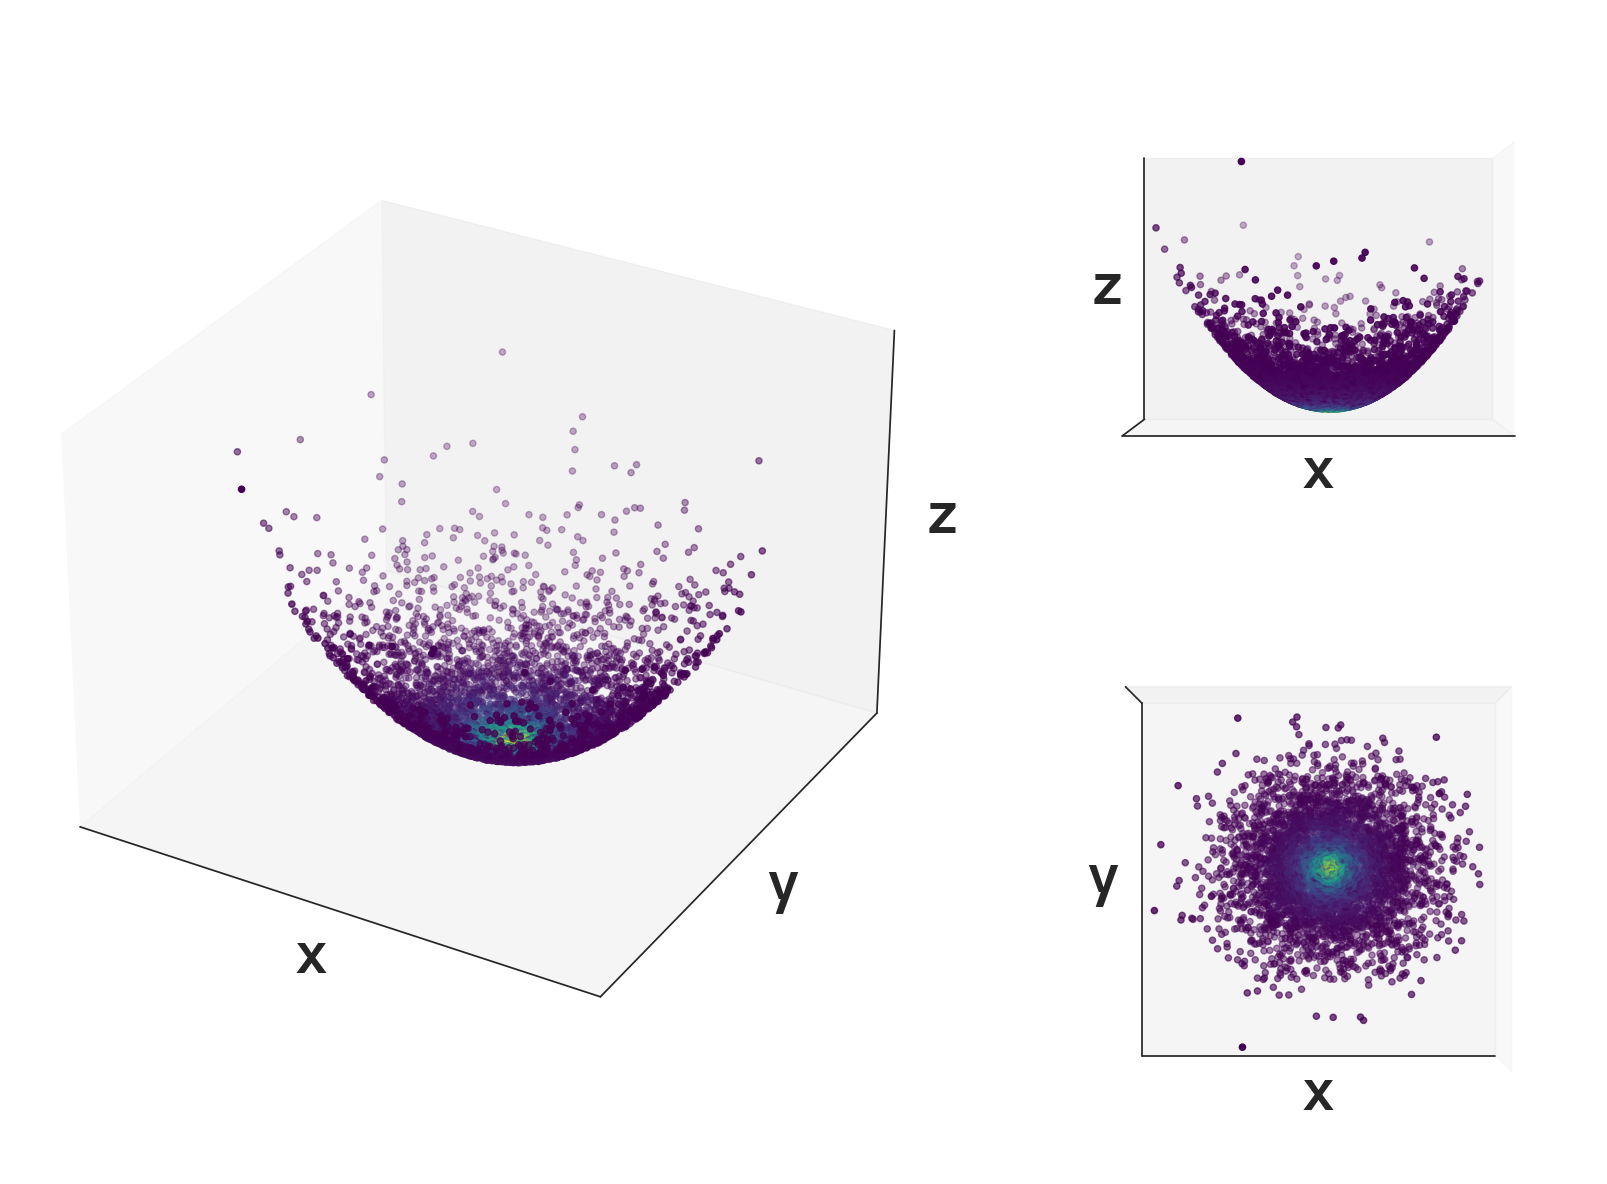

In [5]:
x, y, z = chm["x"], chm["y"], chm["z"]
scores = jnp.exp(tr.get_score())
scores /= jnp.sum(scores)
scores *= 255.0

# Create a new figure
fig = plt.figure(figsize=(18, 12))  # Adjust the size for better visualization

gs = GridSpec(2, 2, height_ratios=[1, 1])
label_fontsize = 42 # Set the desired font size here

# First subplot - Original 3D plot
ax1 = fig.add_subplot(gs[:, 0], projection='3d')  # This spans both columns
ax1.scatter(x, y, z, c = scores, cmap = "viridis")
ax1.set_xlabel("x", fontsize = label_fontsize)
ax1.set_ylabel("y", fontsize = label_fontsize)
ax1.set_zlabel("z", fontsize = label_fontsize)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

# Second subplot - Rotated 3D plot looking at the XZ plane
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax2.scatter(x, y, z, c = scores, cmap = "viridis")
ax2.set_xlabel("x", fontsize = label_fontsize)
ax2.set_zlabel("z", fontsize = label_fontsize)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.view_init(elev=0, azim=-90)

# Third subplot - Rotated 3D plot looking at the XZ plane
ax3 = fig.add_subplot(gs[1, 1], projection='3d')
ax3.scatter(x, y, z, c = scores, cmap = "viridis")
ax3.set_xlabel("x", fontsize = label_fontsize)
ax3.set_ylabel("y", fontsize = label_fontsize)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_zticks([])
ax3.view_init(elev=90, azim=-90)

# Save the figure as an SVG file (optional)
fig.savefig("img/model_prior.pdf", format='pdf')

# Show the plots
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.show()


## Naive variational guide

In [6]:
# Now, we define our variational proposal.
@genjax.gen
def variational_family(data, ϕ):
    μ1, μ2, log_σ1, log_σ2 = ϕ
    x = nablasp.normal_reparam(μ1, jnp.exp(log_σ1)) @ "x"
    y = nablasp.normal_reparam(μ2, jnp.exp(log_σ2)) @ "y"

In [7]:
objective = nablasp.elbo(model, (), variational_family, (), genjax.choice_map({"z": 5.0}))

In [8]:
# Training.
key = jax.random.PRNGKey(314159)
ϕ = (0.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(objective.value_and_grad_estimate, in_axes=(0, None)))
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, (ϕ_grads, )) = jitted(sub_keys, ((), (ϕ, )))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
print(ϕ)

-480.4062
-8.00585
-7.9512496
-7.706367
-8.026703
-7.83136
-8.110046
-7.729438
-7.6874413
-7.869322
-7.8776264
-7.8393297
-7.747447
-7.8564973
-7.859069
-7.8296
-7.804487
-7.8095117
-7.730398
-7.693806
(Array(-2.2071743, dtype=float32), Array(-0.00060714, dtype=float32), Array(-2.8740335, dtype=float32), Array(-1.0170869, dtype=float32))


### Sampling from the trained variational family

In [9]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(sub_keys, (data, ϕ))
chm = tr.strip()

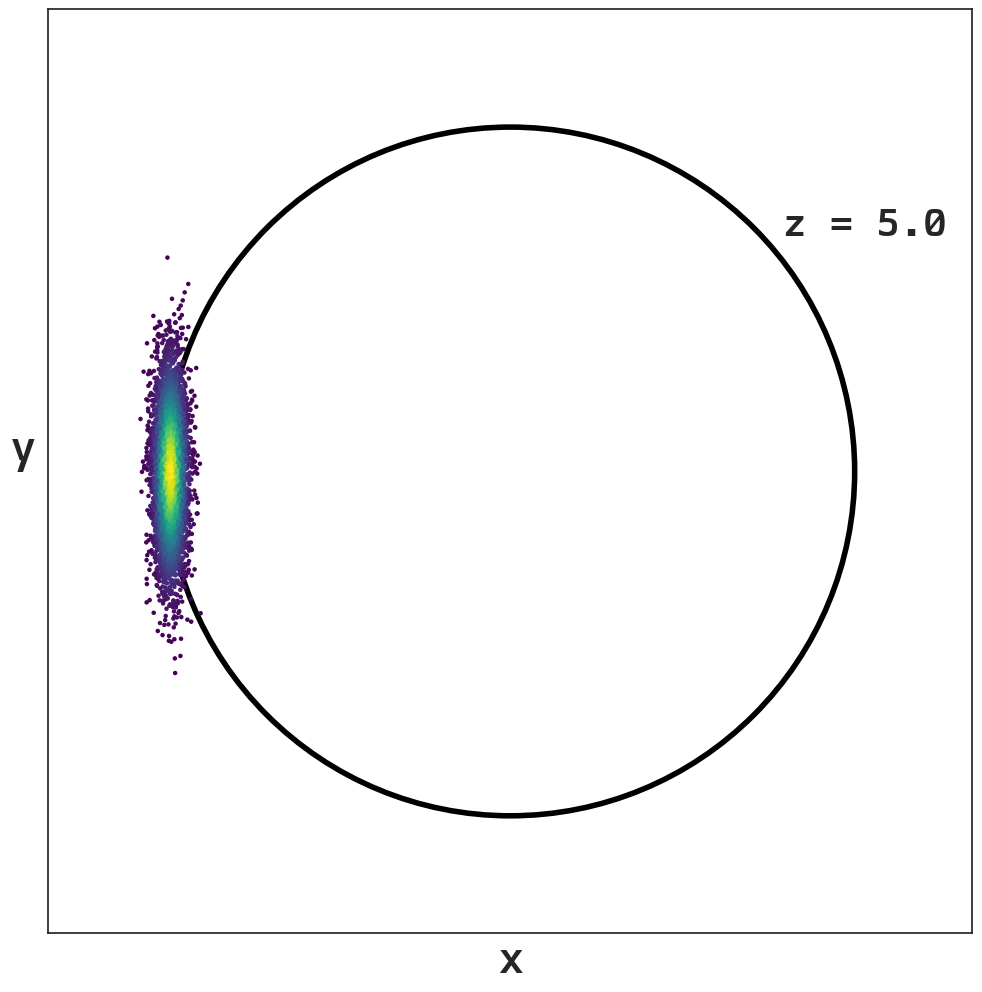

In [10]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())
scores /= jnp.sum(scores)
scores *= 255.0

fig, ax = plt.subplots(figsize=(12, 12))
label_fontsize = 32 # Set the desired font size here

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc='none', ec='black', lw=4)

# Add the circle to the plot
ax.add_patch(circle)

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect('equal')

ax.scatter(x, y, c = scores, cmap = "viridis", marker='.', s=20)

ax.text(2.3, 1.6, "z = 5.0", ha='center', va='center', fontsize=28)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize = label_fontsize)
ax.set_ylabel("y", fontsize = label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

fig.savefig("img/naive_variational_elbo_samples.svg", format='svg')

# Show the plot
plt.show()

## Training with IWAE

In [11]:
iwae_objective = nablasp.iwae_elbo(model, (), 
                                   variational_family, (), 
                                   genjax.choice_map({"z": 5.0}), 5)

In [ ]:
# Training with IWAE.
key = jax.random.PRNGKey(314159)
ϕ = (3.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(iwae_objective.value_and_grad_estimate, in_axes=(0, None)))
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, (ϕ_grads, )) = jitted(sub_keys, ((), (ϕ, )))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
print(ϕ)

-135.16098
-7.1578937
-7.1597795
-7.143113
-7.780651
-7.227538
-7.3859158
-7.15615
-7.2674723
-7.045949
-7.179607
-7.311865
-7.255864
-7.045934
-7.182499
-7.372644
-7.4265804
-7.434273
-7.2049713


In [ ]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(sub_keys, (data, ϕ))
chm = tr.strip()

In [ ]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())
scores /= jnp.sum(scores)
scores *= 255.0

fig, ax = plt.subplots(figsize=(12, 12))
label_fontsize = 32 # Set the desired font size here

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc='none', ec='black', lw=4)

# Add the circle to the plot
ax.add_patch(circle)

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect('equal')

ax.scatter(x, y, c = scores, cmap = "viridis", marker='.', s=20)

ax.text(-2.3, 1.6, "z = 5.0", ha='center', va='center', fontsize=28)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize = label_fontsize)
ax.set_ylabel("y", fontsize = label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

fig.savefig("img/naive_variational_iwae_elbo_5_samples.svg", format='svg')


# Show the plot
plt.show()

In [ ]:
iwae_objective = nablasp.iwae_elbo(model, (), 
                                   variational_family, (), 
                                   genjax.choice_map({"z": 5.0}), 20)

In [ ]:
# Training with IWAE.
key = jax.random.PRNGKey(314159)
ϕ = (3.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(iwae_objective.value_and_grad_estimate, in_axes=(0, None)))
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, (ϕ_grads, )) = jitted(sub_keys, ((), (ϕ, )))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
print(ϕ)

In [ ]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(sub_keys, (data, ϕ))
chm = tr.strip()

In [ ]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())
scores /= jnp.sum(scores)
scores *= 255.0

fig, ax = plt.subplots(figsize=(12, 12))
label_fontsize = 32 # Set the desired font size here

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc='none', ec='black', lw=4)

# Add the circle to the plot
ax.add_patch(circle)

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect('equal')

ax.scatter(x, y, c = scores, cmap = "viridis", marker='.', s=20)

ax.text(-2.3, 1.6, "z = 5.0", ha='center', va='center', fontsize=28)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize = label_fontsize)
ax.set_ylabel("y", fontsize = label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

fig.savefig("img/naive_variational_iwae_elbo_20_samples.svg", format='svg')


# Show the plot
plt.show()

In [ ]:
iwae_objective = nablasp.iwae_elbo(model, (), 
                                   variational_family, (), 
                                   genjax.choice_map({"z": 5.0}), 50)

In [ ]:
# Training with IWAE.
key = jax.random.PRNGKey(314159)
ϕ = (3.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(iwae_objective.value_and_grad_estimate, in_axes=(0, None)))
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, (ϕ_grads, )) = jitted(sub_keys, ((), (ϕ, )))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
print(ϕ)

In [ ]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(sub_keys, (data, ϕ))
chm = tr.strip()

In [ ]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())
scores /= jnp.sum(scores)
scores *= 255.0

fig, ax = plt.subplots(figsize=(12, 12))
label_fontsize = 32 # Set the desired font size here

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc='none', ec='black', lw=4)

# Add the circle to the plot
ax.add_patch(circle)

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect('equal')

ax.scatter(x, y, c = scores, cmap = "viridis", marker='.', s=20)

ax.text(-2.3, 1.6, "z = 5.0", ha='center', va='center', fontsize=28)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize = label_fontsize)
ax.set_ylabel("y", fontsize = label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

fig.savefig("img/naive_variational_iwae_elbo_50_samples.svg", format='svg')

# Show the plot
plt.show()

## Using `marginal`

In [ ]:
# A more expressive variational family.
@genjax.gen
def expressive_variational_family(data, ϕ):
    z = data["z"]
    u = nablasp.uniform() @ "z"
    θ = 2 * jnp.pi * u
    μ1, μ2, log_σ1, log_σ2 = ϕ
    x = nablasp.normal_reparam(jnp.sqrt(z) * jnp.cos(θ), jnp.exp(log_σ1)) @ "x"
    y = nablasp.normal_reparam(jnp.sqrt(z) * jnp.sin(θ), jnp.exp(log_σ2)) @ "y"
    
marginal_q = nablasp.marginal(genjax.select("x", "y"),
                              expressive_variational_family,
                              lambda: nablasp.sir(10))

objective = nablasp.elbo(model, (), marginal_q, (), genjax.choice_map({"z" : 5.0}))

In [ ]:
objective